In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torch.nn.functional as F
import numpy as np

# torch.manual_seed(1)

# Enlarge EPOCH to 5, and set lower learning rate
EPOCH = 15
LR = 0.0001
DOWNLOAD_MNIST = False

train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=torchvision.transforms.ToTensor(),
                                        download=DOWNLOAD_MNIST)
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
print(train_data.train_data.shape)

train_x = torch.unsqueeze(train_data.train_data, dim=1).type(torch.FloatTensor) / 255.
train_y = train_data.train_labels
print(train_x.shape)

test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor) / 255.  # Tensor on GPU
test_y = test_data.test_labels

torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])


E:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
E:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
E:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
E:\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [2]:
test_x.shape

torch.Size([10000, 1, 28, 28])

In [3]:
import matplotlib.pyplot as plt

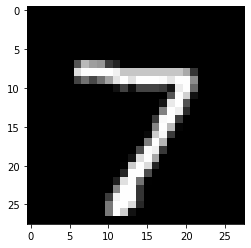

In [4]:
plt.imshow(test_x[0,0,:,:].numpy(), 'gray')

In [5]:
test_y[:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

### 定义神经网络类Net
#### 1. 实现卷积层与全连接层代码
#### 2. 增加dropout与BN技巧
#### 3. 在上次作业的基础上增加ResNet模块

In [6]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

In [7]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Two Layer CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2, bias=True)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2, bias=True)
        
        # Full-Connected Network
        self.fc = nn.Linear(32 * 7 * 7, 10)
       
    
    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.max_pool2d(x1, (2,2)) # Max Pooling with pooling kernel size 2X2
        #x2 = self.res1(x2)
        x3 = F.relu(self.conv2(x2))  
        x4 = F.max_pool2d(x3, (2,2)) # Max Pooling with pooling kernel size 2X2
        #x4 = self.res2(x4)
        x5 = x4.view(x4.size(0), -1)
        x6 = F.relu(self.fc(x5))
        output = F.log_softmax(x6, dim=1)
        
        return output

In [8]:
print(torch.cuda.is_available())

True


In [9]:
# Use multimodels for ensambling
net = Net()

device = torch.device('cuda:0')
net.to(device)

print(net)

optimizer = torch.optim.Adam(net.parameters(), lr=LR)

# loss_func = nn.MSELoss()
loss_func = nn.CrossEntropyLoss()

# Enlarge dataSize and BatchSize
data_size = 60000
batch_size = 100

max_accuracy = 0
best_params = []

for epoch in range(EPOCH):
    random_indx = np.random.permutation(data_size)
    for batch_i in range(data_size // batch_size):
        indx = random_indx[batch_i * batch_size:(batch_i + 1) * batch_size]

        b_x = train_x[indx, :].to(device)
        b_y = train_y[indx].to(device)

        output = net(b_x)
            
        loss = loss_func(output, b_y)
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        if batch_i % 100 == 0:
            test_output = net(test_x.to(device))
            
            # Use voting mechanism to deicide final predicted label
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = torch.sum(pred_y == test_y.to(device)).type(torch.FloatTensor) / test_y.size(0)
            
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.4f' % accuracy)
            if(accuracy > max_accuracy): 
                max_accuracy = accuracy
                torch.save(net, 'best_net.pkl')

test_output = net(test_x[:10].to(device))
pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:10], 'real number')
print('Max Accuracy: %.4f' % max_accuracy)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3021 | test accuracy: 0.0908
Epoch:  0 | train loss: 1.9190 | test accuracy: 0.5088
Epoch:  0 | train loss: 1.2524 | test accuracy: 0.5346
Epoch:  0 | train loss: 1.4743 | test accuracy: 0.5460
Epoch:  0 | train loss: 1.2735 | test accuracy: 0.5538
Epoch:  0 | train loss: 1.0598 | test accuracy: 0.5566
Epoch:  1 | train loss: 1.1421 | test accuracy: 0.5583
Epoch:  1 | train loss: 1.2535 | test accuracy: 0.5595
Epoch:  1 | train loss: 1.3026 | test accuracy: 0.5625
Epoch:  1 | train loss: 1.0319 | test accuracy: 0.5649
Epoch:  1 | train loss: 1.0943 | test accuracy: 0.5680
Epoch:  1 | train loss: 1.3343 | test accuracy: 0.5666
Epoch:  2 | train loss: 1.2649 | test accuracy: 0.5704
Epoch:  2 | train loss: 1.1300 | test accuracy: 0.5713
Epoch:  2

KeyboardInterrupt: 

In [ ]:
net = torch.load('best_net.pkl')

test_output = net(test_x[:20].to(device))
pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

print(pred_y.cpu().numpy(), 'prediction number')
print(test_y[:20].cpu().numpy(), 'real number')

In [11]:
test_x[:1].shape

torch.Size([1, 1, 28, 28])

In [1]:
plt.imshow(test_x[:1].numpy().squeeze(), 'gray')

NameError: name 'plt' is not defined